# Kézzel írt karakterek
Egy ismert és gyakori probléma, hogy kézzel írt számokat ismer fel a neurális hálózat. Erre létezik egy általánosan elterjedt adathalmaz az mnist. A deep learning egyik "hello world!" problémája ez, így rengeteg megoldás és példakód található az interneten ennek megoldására.

## Feladatok
Egy jegyzőkönyv elkészítése amelyben egy, a feladatot jól megoldó modell paramétereit változtatjuk. Vizsgáljuk meg, hogy milyen hatásai vannak a következők közül néhánynak:

- Neuronok számának változtatása
- Rétegek változtatása (rétegek hozzáadása/lecserélése, aktivációs függvények változtatása)
- Költség függvények változtatása
- Tanítási paraméterek állítása(epoch szám, batchsize, learning rate)  

A feladat lényege nem az, hogy minél hosszabb jegyzőkönyv készüljön. Ezért nem kell a fentiek közül minden kombinációt kipróbálni, elég csak minimum 4 külön kísérletet megvalósítani. Ezt jegyzőkönyvhöz hasonló módon tegyétek, azaz minden ábra, tanítási ciklus után egy markdown cellába írjátok le, hogy mi történt, szerintetek miért így történt.  
### Például:
 Beleraktunk plusz kétmillió neuront, nem lett jobb az eredmény, de cserébe sokkal lassabb. Ez azért van, mert ... 
### A házi feladatot jupyter notebook formájában szeretnénk kérni!

## Egyéb információk
Az órán tensorflow keretrendszert használtunk, mert tapasztalataink szerint egyszerűbb elindulni bennne. Mindenkinek szíve joga máshogy gondolni. Aki esetleg pytorchban, vagy más keretrendszerben szeretne dolgozni, nyugodtan megteheti. Akinek kérdése van, keressen nyugodtan teamsen vagy emailben.  
  
Pár hasznos link:
- https://www.tensorflow.org/
- https://nextjournal.com/gkoehler/digit-recognition-with-keras
- https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

# Határidő: 2022. 11. 28

# Kezdeti lépések

**Elősször is minden varázslatot tartalmazó könyvtárat beimportálunk.**

In [1]:
# imports for array-handling and plotting
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

**Betöltjük az adatokat amikkel dolgozni fogunk és utána meg is nézzük őket.**

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

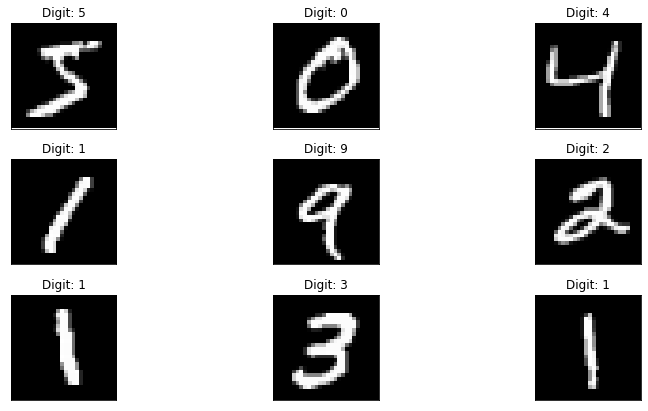

In [3]:
fig = plt.figure(figsize=(12,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])

**A tanuláshoz le kell fordítsuk a képek felbontását 1D-s formátumba, mert jelenleg 2D-s de vektorként tudjuk beadni az algoritmusnak tanulni. Így lesz a** $28$ X $28$ **-as felbontású képünkből egy $28\cdot28 = 784$ elemű vektorunk.**

**Itt most csak megnézzük a pixelértékek eloszlását egy képnél.**

Text(0.5, 1.0, 'Pixel Value Distribution')

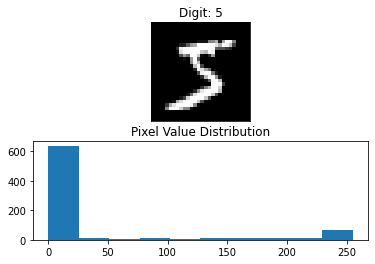

In [4]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")

**Megtörténik a "flatten" művelet.**

In [5]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


**Jelenleg a kódunk még mindig 0-9 terjedő számokat lát, ezen változtatni fogunk.**

In [6]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
      dtype=int64))


**Az új kódolása ezeknek a számoknak a következő elvet követi:**

**A számokhoz hozzá rendelünk egy 10 elemű vektort melynek minden eleme nulla, kivéve azt az elemet, melynek indexe a szám amit kódolni kívántunk a vektorba, ott egy 1-es lesz. Például:**

$$0 = [1,0,0,0,0,0,0,0,0,0]$$

$$4 = [0,0,0,0,1,0,0,0,0,0]$$

In [7]:
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


# A háló megépítése és tanulás

**Két réteg 512 node-al a számok felismeréséhez, és egy 10 node-os a 10 féle kimenetnek megfelelően. Az utolsóban a túltanulást kerüljük el a "Dropout" paranccsal.**

In [8]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

**Kezdődik a varázslat. Az előbb megépítettük a modellt, most elindítjuk a tanulás útján.**

In [9]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Epoch 1/20
469/469 - 13s - loss: 0.2497 - accuracy: 0.9245 - val_loss: 0.1060 - val_accuracy: 0.9663 - 13s/epoch - 27ms/step
Epoch 2/20
469/469 - 11s - loss: 0.1005 - accuracy: 0.9689 - val_loss: 0.0748 - val_accuracy: 0.9765 - 11s/epoch - 23ms/step
Epoch 3/20
469/469 - 11s - loss: 0.0719 - accuracy: 0.9766 - val_loss: 0.0700 - val_accuracy: 0.9761 - 11s/epoch - 23ms/step
Epoch 4/20
469/469 - 11s - loss: 0.0553 - accuracy: 0.9826 - val_loss: 0.0654 - val_accuracy: 0.9797 - 11s/epoch - 23ms/step
Epoch 5/20
469/469 - 11s - loss: 0.0460 - accuracy: 0.9848 - val_loss: 0.0664 - val_accuracy: 0.9809 - 11s/epoch - 23ms/step
Epoch 6/20
469/469 - 11s - loss: 0.0402 - accuracy: 0.9864 - val_loss: 0.0653 - val_accuracy: 0.9814 - 11s/epoch - 23ms/step
Epoch 7/20
469/469 - 11s - loss: 0.0341 - accuracy: 0.9883 - val_loss: 0.0632 - val_accuracy: 0.9825 - 11s/epoch - 24ms/step
Epoch 8/20
469/469 - 11s - loss: 0.0319 - accuracy: 0.9893 - val_loss: 0.0785 - val_accuracy: 0.9778 - 11s/epoch - 23ms/step


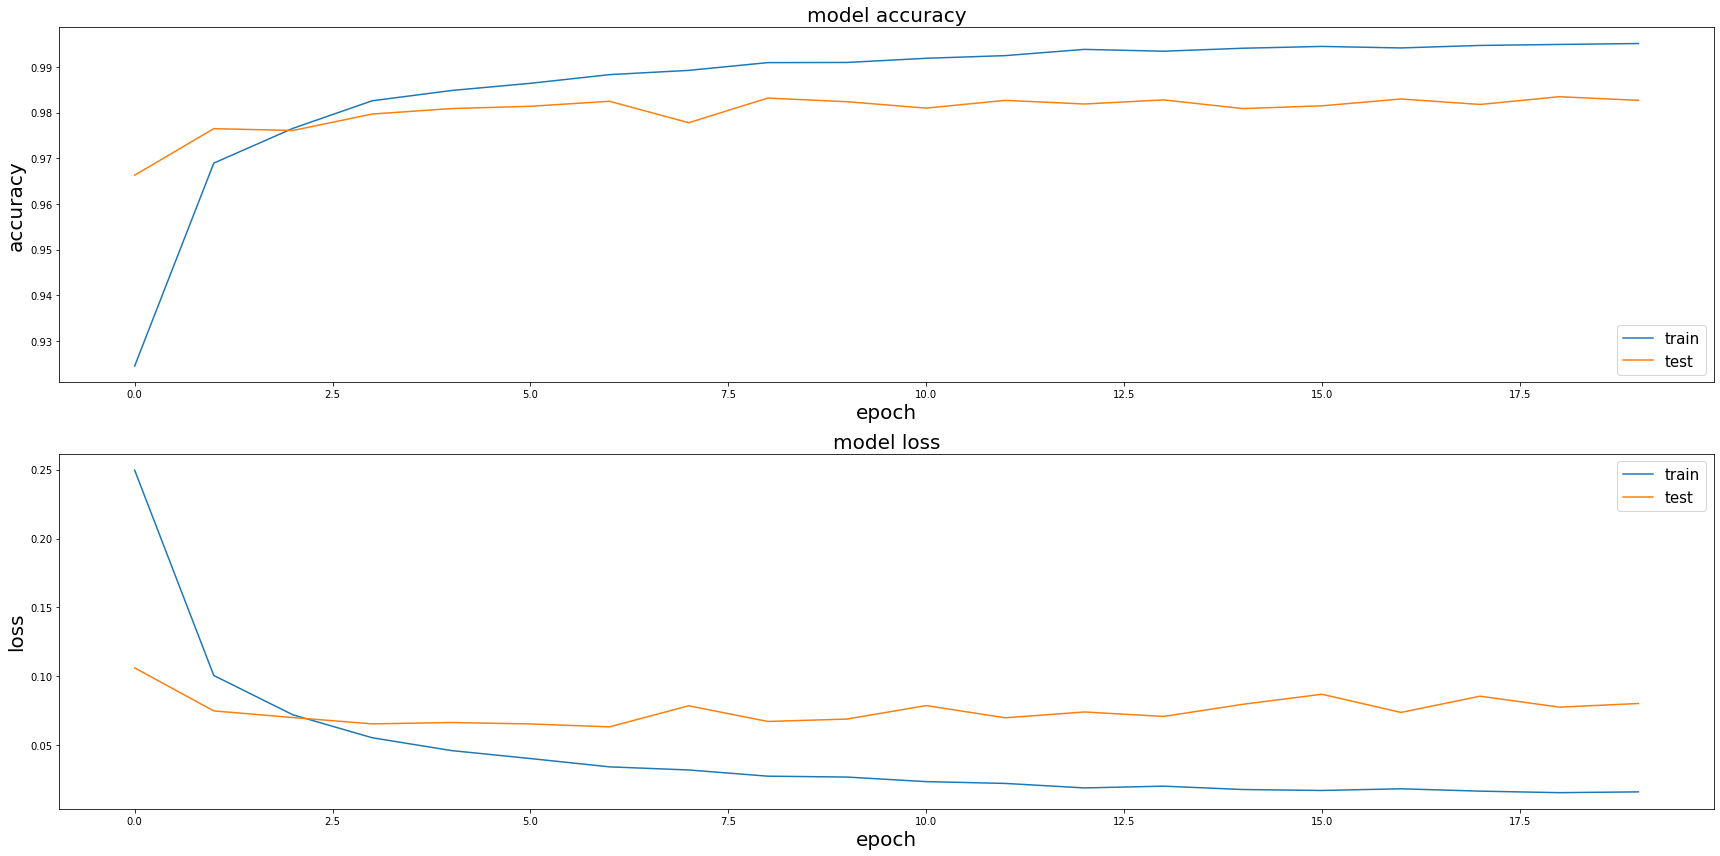

In [10]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "/results/"
model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure(figsize=(24,12))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'test'], loc='lower right',fontsize=15)

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'test'], loc='upper right',fontsize=15)

plt.tight_layout()

In [11]:
mnist_model = load_model('/results/keras_mnist.h5')
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

313/313 - 2s - loss: 0.0802 - accuracy: 0.9827 - 2s/epoch - 5ms/step
Test Loss 0.08016100525856018
Test Accuracy 0.982699990272522


**Most láttuk a pontosságát a modellünknek, valamint a veszteségeket. Most nézzük meg hogy milyen számokat ismer fel a képekről:**

313/313 [==============================] - 2s 4ms/step

9827  classified correctly
173  classified incorrectly


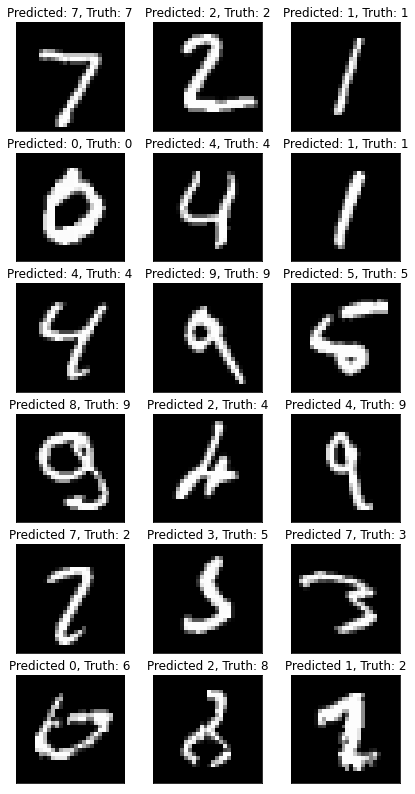

In [12]:
# load the model and create predictions on the test set
mnist_model = load_model('/results/keras_mnist.h5')
predicted_classes = mnist_model.predict(X_test)
predicted_classes=np.argmax(predicted_classes,axis=1)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

**Azt látjuk, hogy többnyire eredményes a tanulás, amiket eltévesztett azokat egy ember is megkérdőjelezné.**

**Nézzük meg más beállítások mellet, mi változik:**

- Neuronok számának változtatása
- Rétegek változtatása (rétegek hozzáadása/lecserélése, aktivációs függvények változtatása)
- Költség függvények változtatása
- Tanítási paraméterek állítása(epoch szám, batchsize, learning rate)  

## Kevesebb réteg esete

Epoch 1/20
469/469 - 4s - loss: 0.4024 - accuracy: 0.8787 - val_loss: 0.1586 - val_accuracy: 0.9509 - 4s/epoch - 9ms/step
Epoch 2/20
469/469 - 3s - loss: 0.1779 - accuracy: 0.9463 - val_loss: 0.1160 - val_accuracy: 0.9651 - 3s/epoch - 6ms/step
Epoch 3/20
469/469 - 3s - loss: 0.1348 - accuracy: 0.9589 - val_loss: 0.0973 - val_accuracy: 0.9701 - 3s/epoch - 6ms/step
Epoch 4/20
469/469 - 3s - loss: 0.1099 - accuracy: 0.9661 - val_loss: 0.0828 - val_accuracy: 0.9758 - 3s/epoch - 6ms/step
Epoch 5/20
469/469 - 3s - loss: 0.0958 - accuracy: 0.9710 - val_loss: 0.0790 - val_accuracy: 0.9763 - 3s/epoch - 6ms/step
Epoch 6/20
469/469 - 3s - loss: 0.0839 - accuracy: 0.9737 - val_loss: 0.0768 - val_accuracy: 0.9764 - 3s/epoch - 6ms/step
Epoch 7/20
469/469 - 3s - loss: 0.0733 - accuracy: 0.9767 - val_loss: 0.0713 - val_accuracy: 0.9780 - 3s/epoch - 6ms/step
Epoch 8/20
469/469 - 3s - loss: 0.0674 - accuracy: 0.9784 - val_loss: 0.0697 - val_accuracy: 0.9780 - 3s/epoch - 6ms/step
Epoch 9/20
469/469 - 3s 

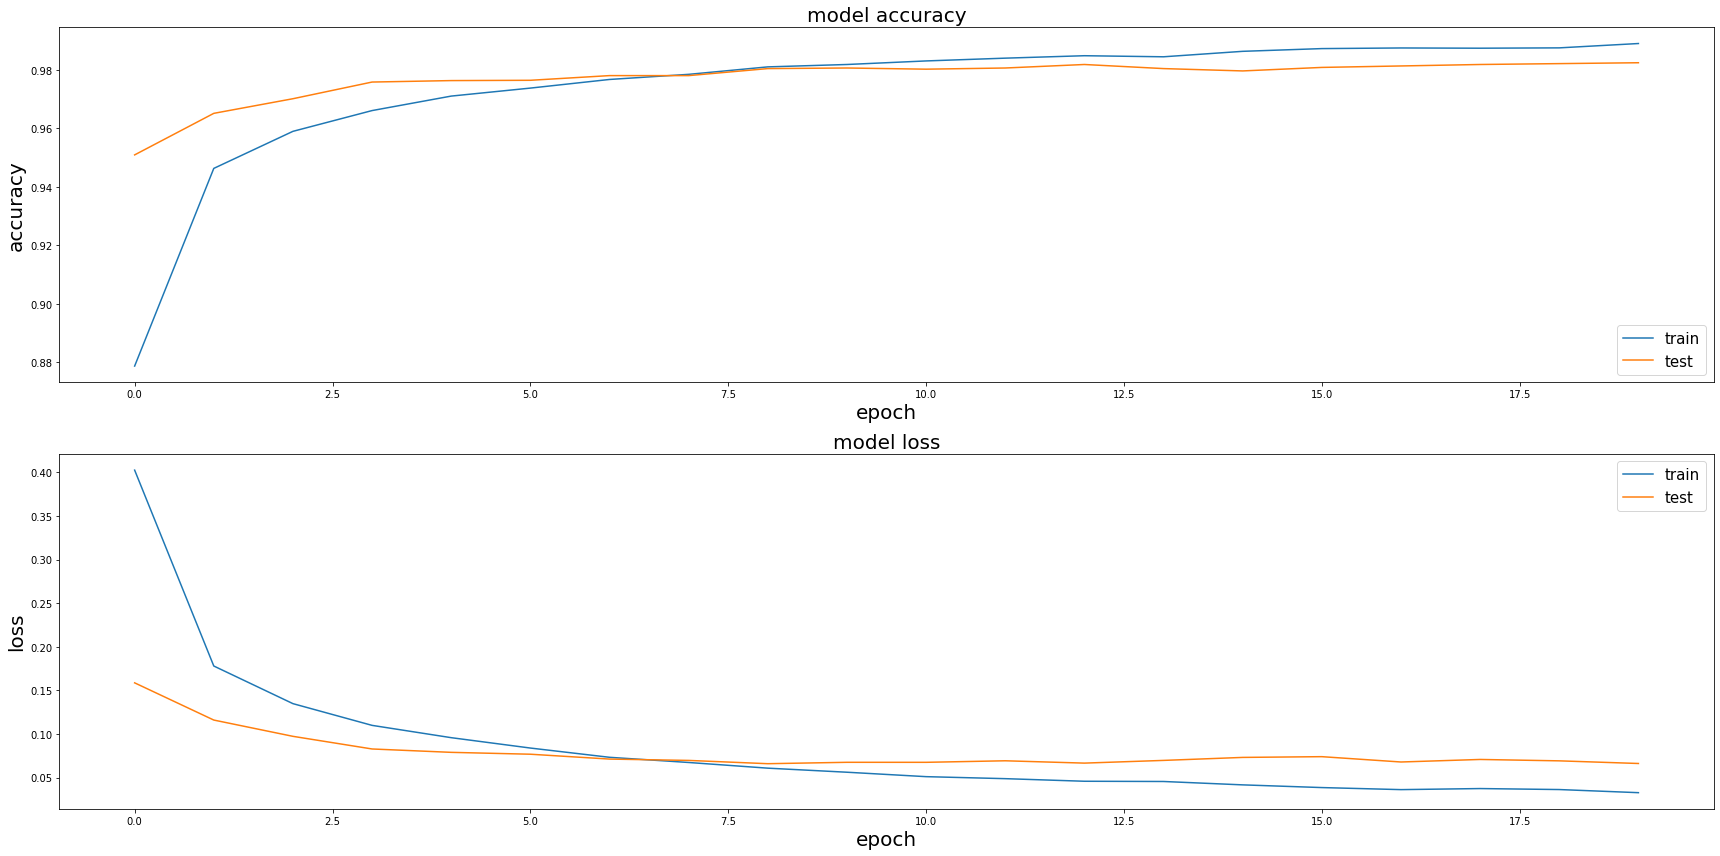

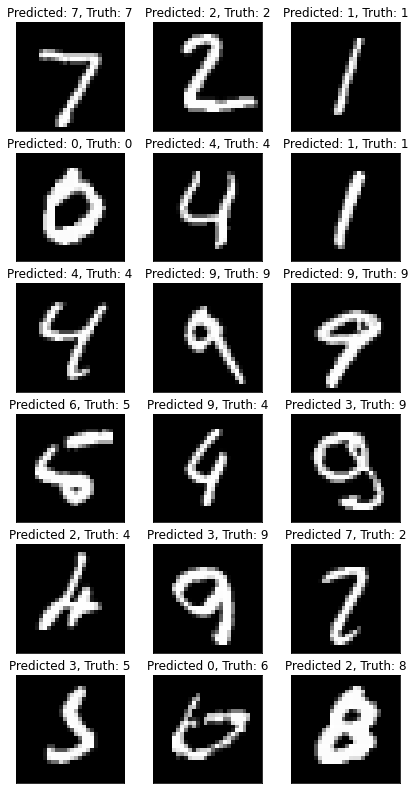

In [13]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(128, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "/results/"
model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure(figsize=(24,12))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'test'], loc='lower right',fontsize=15)

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'test'], loc='upper right',fontsize=15)

plt.tight_layout()

mnist_model = load_model('/results/keras_mnist.h5')
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

# load the model and create predictions on the test set
mnist_model = load_model('/results/keras_mnist.h5')
predicted_classes = mnist_model.predict(X_test)
predicted_classes=np.argmax(predicted_classes,axis=1)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

**Kétszer gyorsabb volt, de cserébe pontatlanabb bár az már nem kétszeresen. Az eredetihez képest 21 esetben rosszul tippelt.**

**A kevesebb réteg olyasmi mintha kevesebbszer ismételgetné el a memoritert az iskolás. A rétegeken megy keresztül a bemeneti információ, ezt a megadott függvény alapján feldolgozza, az eredményét/kimenetet pedig tovább adja a következő rétegnek. Most ezen rétegek számát feleztem meg, emiatt hamarabb a végére ért természetesen, de pont emiatt kicsit gyengébb is lett a vizsgája.**

## Epoch szám csökkentése

Epoch 1/10
469/469 - 12s - loss: 0.2508 - accuracy: 0.9246 - val_loss: 0.0986 - val_accuracy: 0.9656 - 12s/epoch - 26ms/step
Epoch 2/10
469/469 - 11s - loss: 0.0985 - accuracy: 0.9694 - val_loss: 0.0712 - val_accuracy: 0.9782 - 11s/epoch - 23ms/step
Epoch 3/10
469/469 - 10s - loss: 0.0711 - accuracy: 0.9779 - val_loss: 0.0670 - val_accuracy: 0.9784 - 10s/epoch - 22ms/step
Epoch 4/10
469/469 - 10s - loss: 0.0565 - accuracy: 0.9819 - val_loss: 0.0704 - val_accuracy: 0.9790 - 10s/epoch - 22ms/step
Epoch 5/10
469/469 - 11s - loss: 0.0453 - accuracy: 0.9845 - val_loss: 0.0675 - val_accuracy: 0.9806 - 11s/epoch - 23ms/step
Epoch 6/10
469/469 - 11s - loss: 0.0367 - accuracy: 0.9882 - val_loss: 0.0619 - val_accuracy: 0.9817 - 11s/epoch - 22ms/step
Epoch 7/10
469/469 - 11s - loss: 0.0365 - accuracy: 0.9883 - val_loss: 0.0650 - val_accuracy: 0.9820 - 11s/epoch - 23ms/step
Epoch 8/10
469/469 - 11s - loss: 0.0296 - accuracy: 0.9898 - val_loss: 0.0641 - val_accuracy: 0.9823 - 11s/epoch - 22ms/step


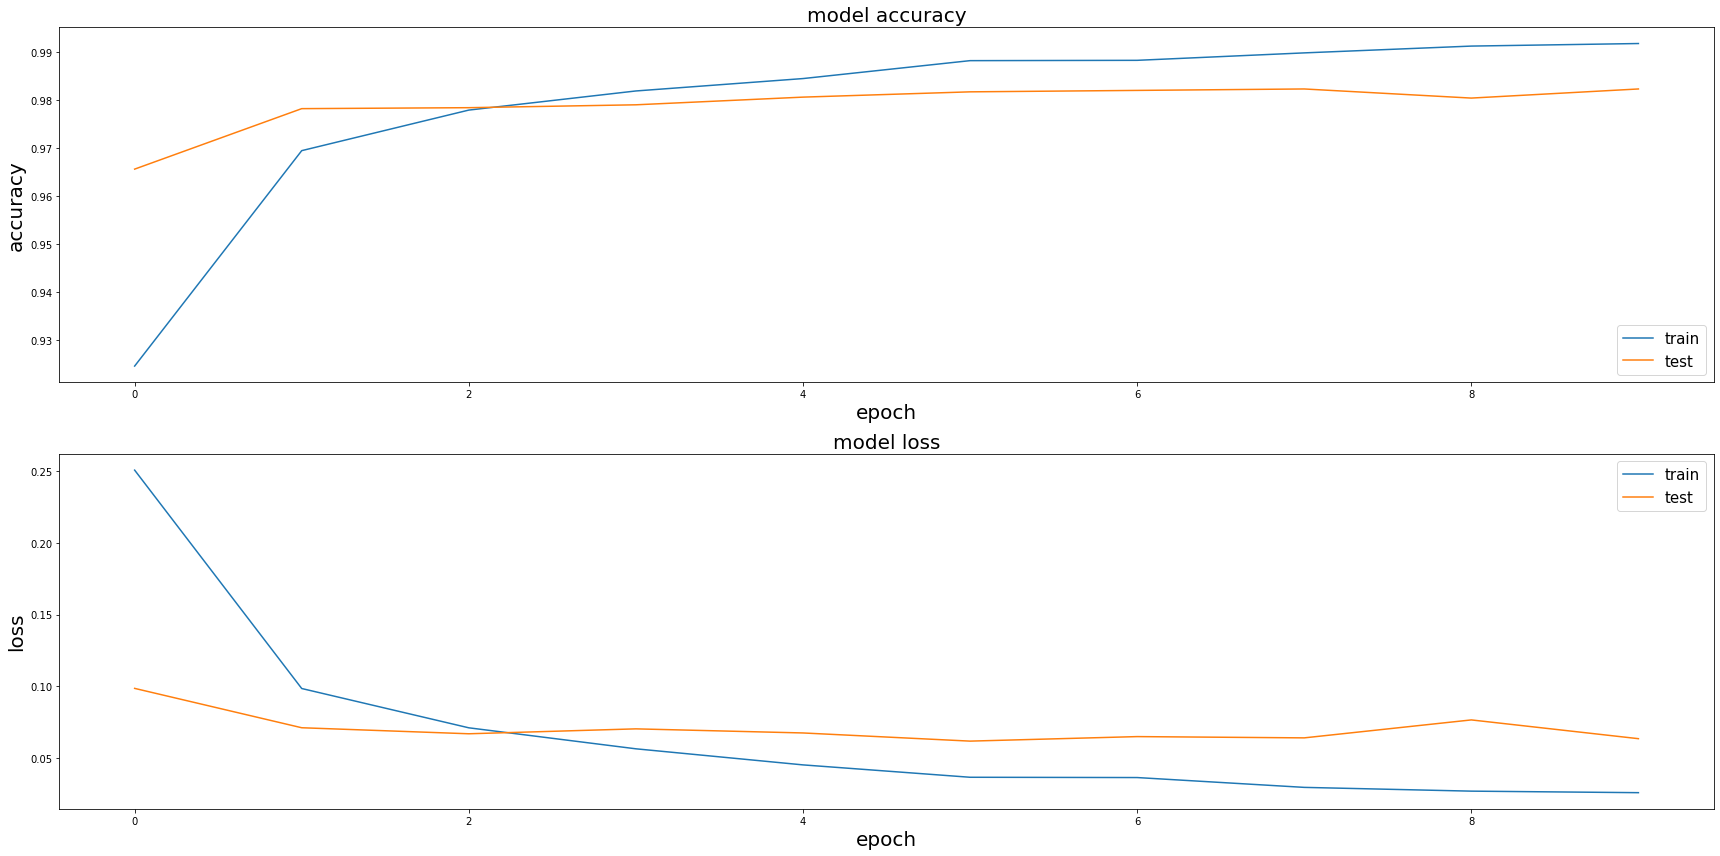

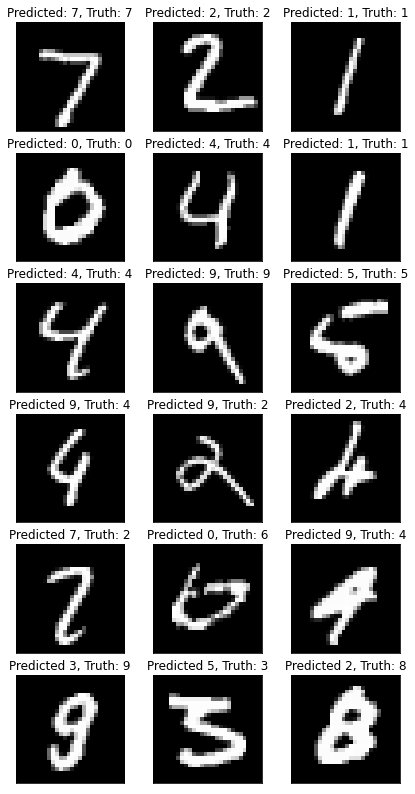

In [14]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=10,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "/results/"
model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure(figsize=(24,12))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'test'], loc='lower right',fontsize=15)

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'test'], loc='upper right',fontsize=15)

plt.tight_layout()

mnist_model = load_model('/results/keras_mnist.h5')
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

# load the model and create predictions on the test set
mnist_model = load_model('/results/keras_mnist.h5')
predicted_classes = mnist_model.predict(X_test)
predicted_classes=np.argmax(predicted_classes,axis=1)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

**A gyorsaságán javított de a lépésekre bontott idő a végén nem különbözik szignifikánsan az eredetitől, csakúgy mint a loss és accuracy-je.**

**Az epoch száma azt adja meg, hogy a képzési adathalmaz (training data) hányszor járja körbe az algoritmust. Ennek ismeretében egyértelmű következmény a sebességében vett változás, azonban az már hogy az eredményekben miért nincs esetleges romlás amire számítana az ember, érdekesebb. Azt mondanám, az ábrákra hivatkozva, hogy akár ~5 epoch számnál is elérhetünk hasonló eredményeket mint 20-nál, nem hogy 10-nél. Tehát igazából romlott is a pontossága, de elhanyagolhatóan pici összevetve az eredetivel.**

## Batchsize növelése

Epoch 1/20
235/235 - 9s - loss: 0.3009 - accuracy: 0.9111 - val_loss: 0.1172 - val_accuracy: 0.9635 - 9s/epoch - 38ms/step
Epoch 2/20
235/235 - 7s - loss: 0.1139 - accuracy: 0.9643 - val_loss: 0.0900 - val_accuracy: 0.9708 - 7s/epoch - 31ms/step
Epoch 3/20
235/235 - 7s - loss: 0.0780 - accuracy: 0.9757 - val_loss: 0.0664 - val_accuracy: 0.9788 - 7s/epoch - 31ms/step
Epoch 4/20
235/235 - 7s - loss: 0.0575 - accuracy: 0.9818 - val_loss: 0.0710 - val_accuracy: 0.9771 - 7s/epoch - 31ms/step
Epoch 5/20
235/235 - 7s - loss: 0.0475 - accuracy: 0.9847 - val_loss: 0.0666 - val_accuracy: 0.9784 - 7s/epoch - 31ms/step
Epoch 6/20
235/235 - 7s - loss: 0.0363 - accuracy: 0.9883 - val_loss: 0.0616 - val_accuracy: 0.9822 - 7s/epoch - 31ms/step
Epoch 7/20
235/235 - 7s - loss: 0.0323 - accuracy: 0.9895 - val_loss: 0.0577 - val_accuracy: 0.9814 - 7s/epoch - 32ms/step
Epoch 8/20
235/235 - 8s - loss: 0.0284 - accuracy: 0.9902 - val_loss: 0.0586 - val_accuracy: 0.9818 - 8s/epoch - 32ms/step
Epoch 9/20
235/2

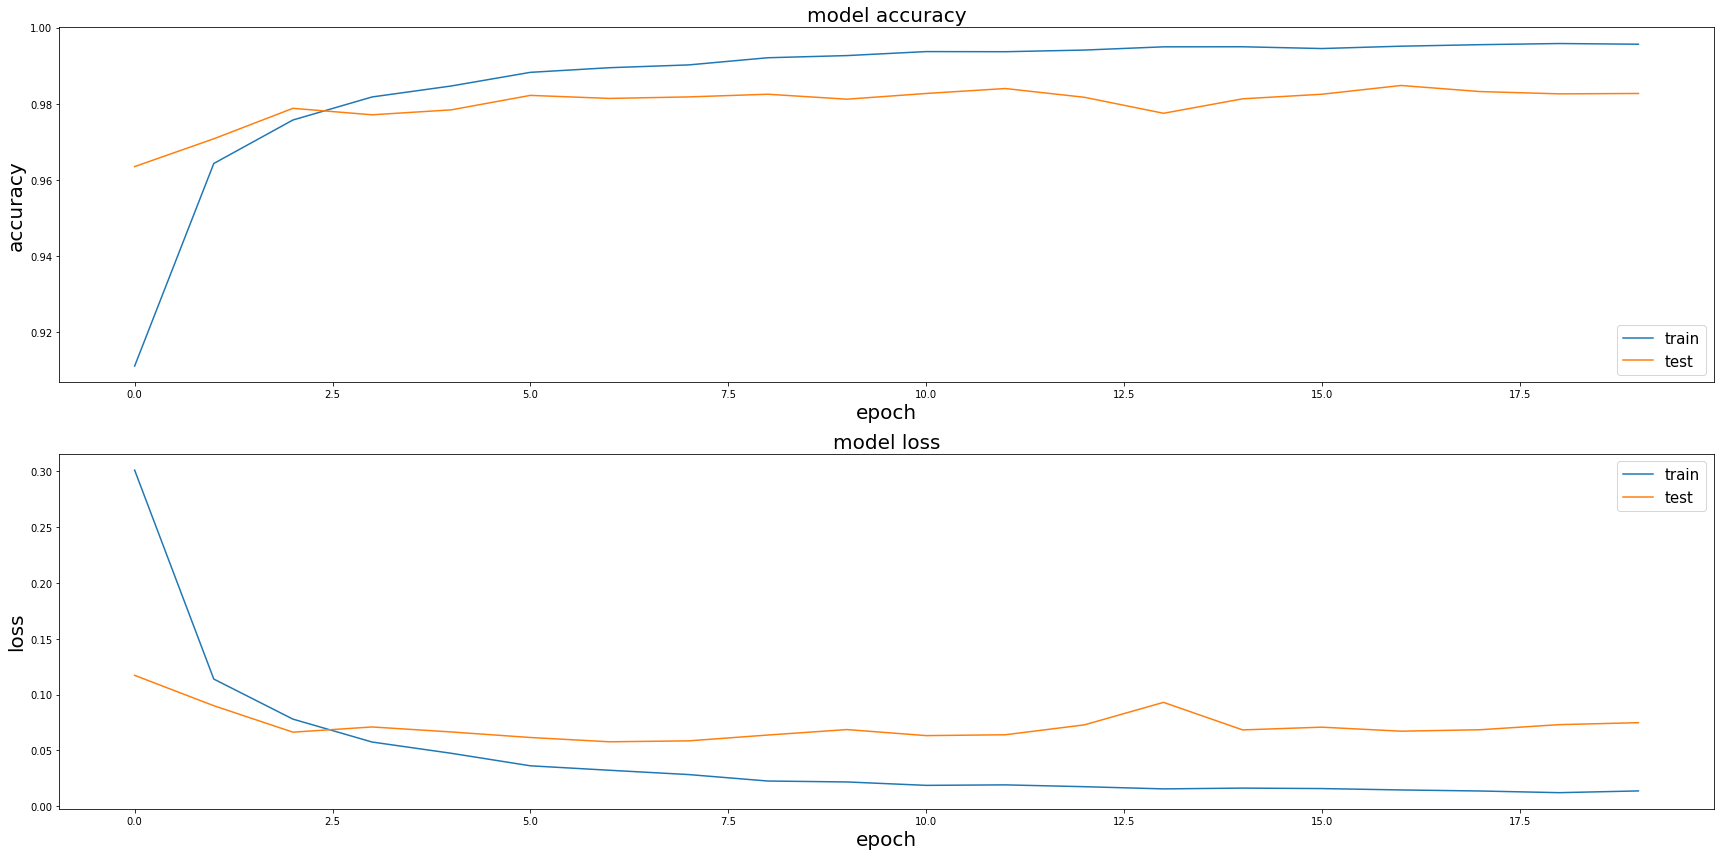

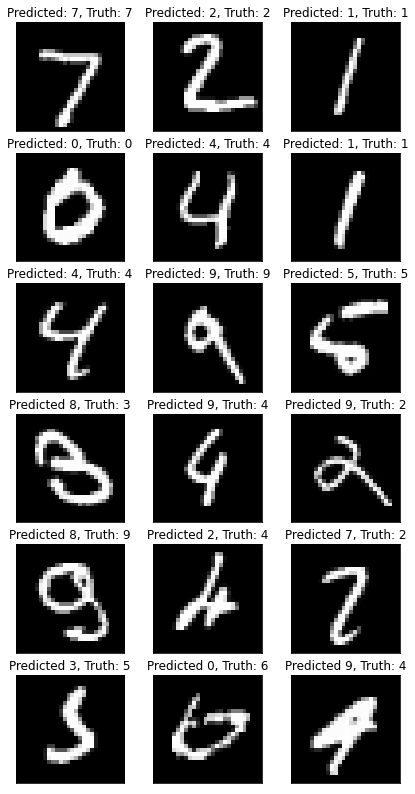

In [15]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=256, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "/results/"
model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure(figsize=(24,12))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'test'], loc='lower right',fontsize=15)

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'test'], loc='upper right',fontsize=15)

plt.tight_layout()

mnist_model = load_model('/results/keras_mnist.h5')
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

# load the model and create predictions on the test set
mnist_model = load_model('/results/keras_mnist.h5')
predicted_classes = mnist_model.predict(X_test)
predicted_classes=np.argmax(predicted_classes,axis=1)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

**Valamivel pontatlanabb lett mint az eredetinél de a lépésekre vett ideje gyorsabb 1 teljes másodperccel.**

**A batchsize a modell belső paramétereinek frissítése előtt feldolgozandó gyakorló minták számát szabályozza. Ennek kétszeresére növelésével tulajdonképpen az adathalmazomat kétszer annyi felé daraboltam, mint az első esetben, és** $SampleNums / 256$ **batch-et használok. Ez a**$epoch=20$ **esetén úgy jelenik meg, hogy minden egyes epochban ennyi batchet fog vizsgálni. Azért lett gyorsabb mert több részre osztottam az adathalmazt, de az epoch-on nem változtattam, így egy körben kevesebb batchet kellett vizsgáljon. DE éppen ezért is lett pontatlanabb.**